<h4> Part 2 covers the following : </h4>
    <ol>
    <li> Data Preprocessing </li>
    <li> Dimensionality Reduction using PCA </li>
    <li> Balancing the dataset using SMOTE </li>
    <li> Hyperparameter Tuning using Grid Search </li>
    <li> Model Evaluation and Performance Metrics </li>
    <li> Interactive Visualizations using Plotly  </li>
    </ol>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
df = pd.read_csv('label_encoded_customer_data.csv', low_memory=False)
df.shape

(2434863, 24)

In [3]:
df.head(2)

customer_id  gender   age home_address  annual_income  vip_status  \
0  142932463.0       0  29.0        55100       33144.36           0   
1  133599134.0       1  26.0        84900       21600.00           0   

   no_of_dependents  app_status  opt_out  cust_active_credit_card  \
0               3.0           0        0                        0   
1               0.0           0        0                        0   

   multiple_credit_card  supp_card credit_card_branch  active_prepaid_card  \
0                     0          0                  -                    0   
1                     0          0                  -                    0   

   supp_prepaid_card  multiple_prepaid_card  prepaid_card_branch  \
0                  0                      0                    0   
1                  0                      0                    0   

   active_finance_product  curr_loan_bal  sanctioned_amount  \
0                       1        2768.56             2221.0   
1                       1       17226.60            15000.0   

   multiple_fin_product  fin_product_branch  default  income_category  
0                     1                   0        0                0  
1                     0                   1        0                3

<h5> 
    <li> From the heatmap, we can remove the column 'supp_prepaid_card' since all the values are listed as '0' / 'N' .
         It will not impact the result. 
    </li> 
    <li> We shd replace the income, age, curr_loan_bal, sanctioned_amount, with mean.         
    </li>
    <li> We need to re-update the income category after filling the null values with mean 
    </li>
    <li> We need to drop the rows with null values (383) for no of dependents...we cant replace it with null
    </li>
    
</h5>

In [4]:
# Dropped unwanted col
df.drop(columns = ['supp_prepaid_card','credit_card_branch','home_address'], inplace=True) 

In [5]:
# Dropped null values
df.dropna(subset = ['no_of_dependents'], inplace=True)

In [6]:
# Replacing null values with mean
for col in ['annual_income', 'age', 'curr_loan_bal', 'sanctioned_amount']:
    df[col].fillna(df[col].mean(), inplace=True)

In [7]:
def income_category(annual_income):
    if annual_income <= 5000:
        return 'Low income'
    elif annual_income <= 15000:
        return 'Middle income'
    elif annual_income <= 30000:
        return 'Upper middle income'
    elif annual_income <= 50000:
        return 'High income'
    else:
        return 'Very high income'
le = LabelEncoder()
df['income_category'] = df['annual_income'].apply(income_category)
df['income_category'] = le.fit_transform(df['income_category'])
df.drop(columns = ['annual_income'], inplace=True) 

In [8]:
df.isna().sum()

customer_id                0
gender                     0
age                        0
vip_status                 0
no_of_dependents           0
app_status                 0
opt_out                    0
cust_active_credit_card    0
multiple_credit_card       0
supp_card                  0
active_prepaid_card        0
multiple_prepaid_card      0
prepaid_card_branch        0
active_finance_product     0
curr_loan_bal              0
sanctioned_amount          0
multiple_fin_product       0
fin_product_branch         0
default                    0
income_category            0
dtype: int64

In [9]:
df1 = df.copy()

<h1> Checking if the data is balanced or not </h1>

In [10]:
# Check the distribution of the target variable
print(df1['default'].value_counts(normalize=True))

0    0.726793
1    0.273207
Name: default, dtype: float64


In [11]:
df1.default.value_counts()

0    1769364
1     665116
Name: default, dtype: int64

<h1> Moving into spliting training and testing set </h1>

In [13]:
# Separating the features and the target variable
X = df1.drop(['default'], axis=1)
y = df1['default']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reduced the dimensionality of the features using PCA
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Balancing the dataset using SMOTE [50% : 50%]
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [14]:
# Defining the model
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
# Compiled the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
70763/70763 [==============================] - 171s 2ms/step - loss: 0.5858 - accuracy: 0.7071 - val_loss: 0.8888 - val_accuracy: 0.3795
Epoch 2/10
70763/70763 [==============================] - 151s 2ms/step - loss: 0.5813 - accuracy: 0.7101 - val_loss: 0.8276 - val_accuracy: 0.4137
Epoch 3/10
70763/70763 [==============================] - 150s 2ms/step - loss: 0.5807 - accuracy: 0.7110 - val_loss: 0.8270 - val_accuracy: 0.4125
Epoch 4/10
70763/70763 [==============================] - 153s 2ms/step - loss: 0.5801 - accuracy: 0.7113 - val_loss: 0.8560 - val_accuracy: 0.4048
Epoch 5/10
70763/70763 [==============================] - 156s 2ms/step - loss: 0.5800 - accuracy: 0.7113 - val_loss: 0.8628 - val_accuracy: 0.3973
Epoch 6/10
70763/70763 [==============================] - 160s 2ms/step - loss: 0.5800 - accuracy: 0.7111 - val_loss: 0.8503 - val_accuracy: 0.4088
Epoch 7/10
70763/70763 [==============================] - 160s 2ms/step - loss: 0.5798 - accuracy: 0.7114 - val_

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

15216/15216 [==============================] - 27s 2ms/step - loss: 0.5189 - accuracy: 0.7734
Test Loss: 0.52
Test Accuracy: 77.34%


In [ ]:
# # Defining the parameter grid
# param_grid = {
#     'hidden_layer_sizes': [(32,), (64,), (32, 16), (64, 32)],
#     'activation': ['relu', 'tanh'],
#     'alpha': [0.001, 0.01, 0.1]
# }

# # Defining the grid search object
# grid_search = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=5, n_jobs=-1)

# # Fitted the grid search object to the data
# grid_search.fit(X_train, y_train)

# # Prints the best hyperparameters
# print(f'Best Hyperparameters: {grid_search.best_params_}')

# Defining the parameter grid
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (32, 16), (64, 32)],
    'activation': [ 'relu'],
    'alpha': [0.001, 0.01, 0.1]
}

# Defining the grid search object
grid_search = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=5, n_jobs=-1)

# Fitted the grid search object to the data
grid_search.fit(X_train, y_train)

# Prints the best hyperparameters
print(f'Best Hyperparameters: {grid_search.best_params_}')


In [16]:
# Making predictions on the testing data
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# Printing the confusion matrix and classification report
report = classification_report(y_test, y_pred, output_dict=True ) # for the chart
print(classification_report(y_test, y_pred))

cr = classification_report(y_test, y_pred) # for the charts

# Calculating the AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate the false positive rate and true positive rate for the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)


15216/15216 [==============================] - 18s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85    354121
           1       0.63      0.40      0.49    132775

    accuracy                           0.77    486896
   macro avg       0.72      0.66      0.67    486896
weighted avg       0.76      0.77      0.75    486896



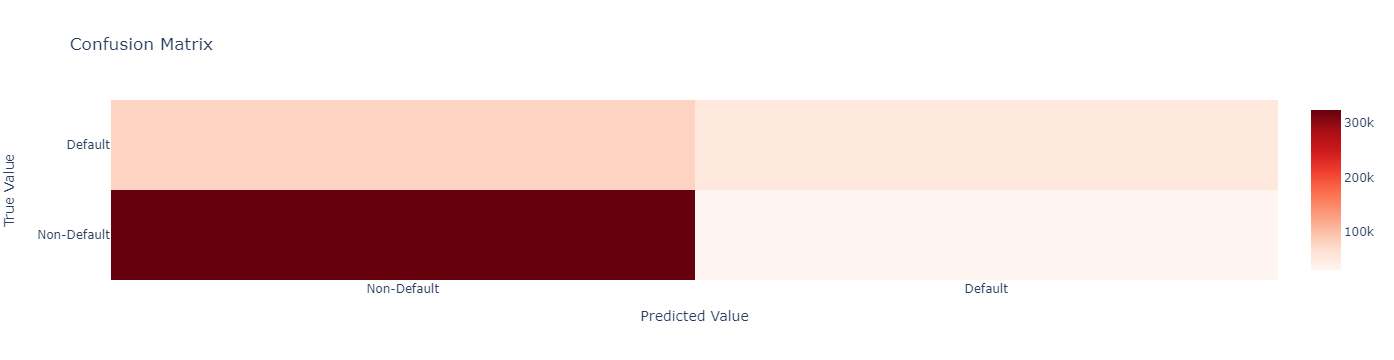

In [17]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig_cm = go.Figure(data=go.Heatmap(z=conf_matrix, x=['Non-Default', 'Default'], y=['Non-Default', 'Default'],colorscale='Reds'))
fig_cm.update_layout(title='Confusion Matrix', xaxis_title='Predicted Value', yaxis_title='True Value')
fig_cm.show()


In [18]:
# Plot the classification report
fig_cr = go.Figure(data=[go.Table(header=dict(values=['Class', 'Precision', 'Recall', 'F1-Score', 'Support']),
                 cells=dict(values=[['0', '1', 'accuracy', 'macro avg', 'weighted avg'],
                                    [cr.split()[12], cr.split()[13], cr.split()[14], cr.split()[15], cr.split()[16]],
                                    [cr.split()[0], cr.split()[1], cr.split()[17], cr.split()[3], cr.split()[6]],
                                    [cr.split()[4], cr.split()[5], cr.split()[18], cr.split()[7], cr.split()[10]],
                                    [cr.split()[8], cr.split()[9], cr.split()[19], cr.split()[11], cr.split()[12]]]))])
fig_cr.update_layout(title='Classification Report')
fig_cr.show()

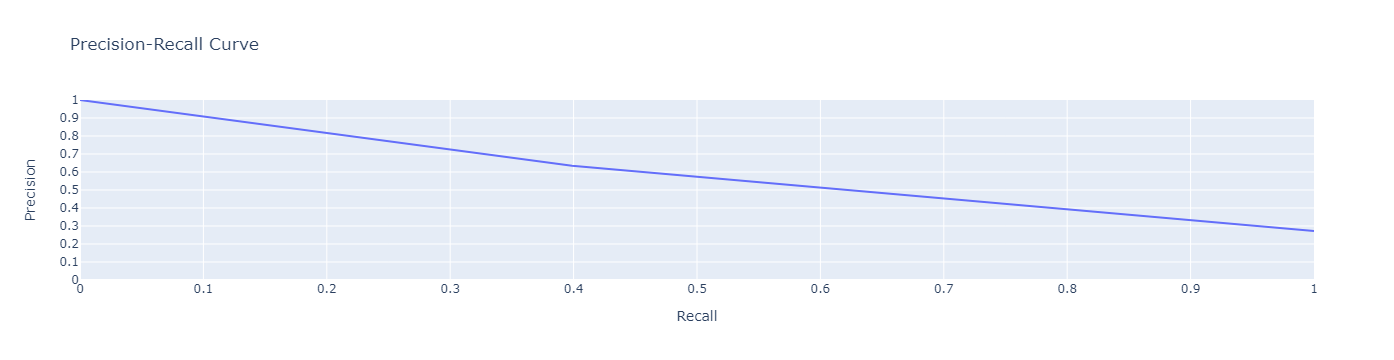

In [19]:
# Plot the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fig_pr = px.line(x=recall, y=precision, title='Precision-Recall Curve', labels=dict(x='Recall', y='Precision'))
fig_pr.update_xaxes(range=[0, 1], dtick=0.1)
fig_pr.update_yaxes(range=[0, 1], dtick=0.1)
fig_pr.show()

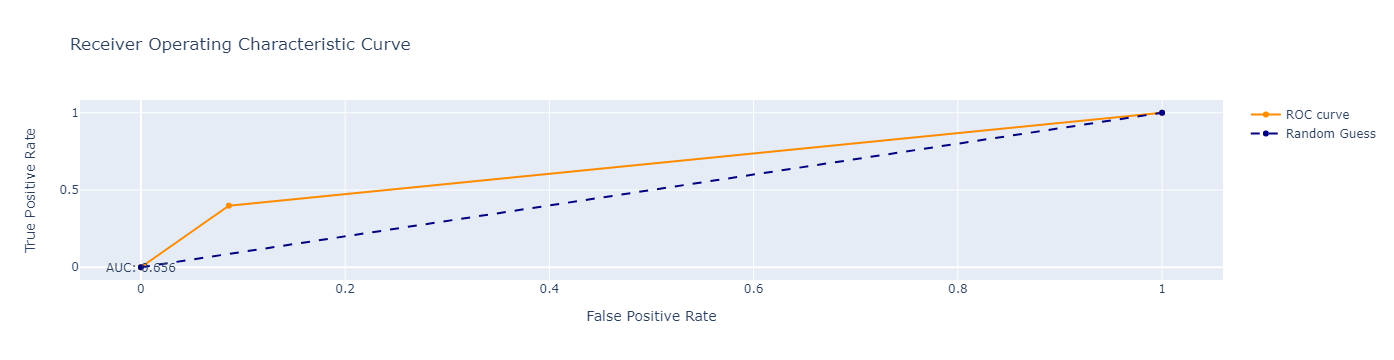

In [20]:
# Plot ROC curve
fig = go.Figure()
fpr, tpr, _ = roc_curve(y_test, y_pred)
fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC curve', line=dict(color='darkorange', width=2)))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='Random Guess', line=dict(color='navy', width=2, dash='dash')))
fig.update_layout(title='Receiver Operating Characteristic Curve',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  annotations=[go.layout.Annotation(x=0, y=0, showarrow=False, text=f'AUC: {roc_auc_score(y_test, y_pred):.3f}')])
fig.show()

In [21]:
# Plot the F1 score
f1_score = report['1']['f1-score']
fig_f1 = go.Figure(data=go.Indicator(mode='gauge+number', value=f1_score,
                                      title={'text': 'F1 Score'},
                                      gauge={'axis': {'range': [0, 1]}, 'steps': [{'range': [0, 1], 'color': 'lightgray'}]},
                                      number={'suffix': '', 'valueformat': '.2f', 'font': {'size': 36}}))
fig_f1.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_fscore_support
# Calculate the precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)

# Create a Plotly figure for the ROC curve, precision, recall, and F1 score
fig = make_subplots(rows=2, cols=2, subplot_titles=('Precision', 'Recall', 'F1 Score'))
fig.add_trace(
    go.Bar(x=['Non-default', 'Default'], y=precision, name='Precision'),
    row=1, col=1)
fig.add_trace(
    go.Bar(x=['Non-default', 'Default'], y=recall, name='Recall'),
    row=1, col=2)
fig.add_trace(
    go.Bar(x=['Non-default', 'Default'], y=f1, name='F1 Score'),
    row=2, col=1)
fig.update_layout(
    title='Model Evaluation',
    xaxis_title='',
    yaxis_title='',
    showlegend=False
)
fig.show()